<a href="https://colab.research.google.com/github/mardzien/machine_learning/blob/main/nlp_disaster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import os
import random
from random import randint

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub

In [ ]:
# input data
data_path = "drive/MyDrive/Kaggle/nlp-getting-started"

In [ ]:
train_path = os.path.join(data_path, "train.csv")
test_path = os.path.join(data_path, "test.csv")
sample_submission_path = os.path.join(data_path, "sample_submission.csv")

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [ ]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
# I want to build and test model first
# Maybe later i will try to join kaggle competition
df = train_df[['text', 'target']]

In [ ]:
# let's check if classes are balanced
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# let's vizualiza some random tweets and see how can I clean them

def show_random_tweets(df=df, text_col="text", label_col="target", n=10):
  for _ in range(n):
    rand_index = randint(0, len(df))
    print(f"""Tweet: {df[text_col].iloc[rand_index]}
Label: {df[label_col].iloc[rand_index]}
--------------------------""")

In [ ]:
show_random_tweets()

Tweet: 10th death confirmed in Legionnaires' outbreak in South Bronx; total cases reaches triple digits http://t.co/JtzefipdBo
Label: 1
--------------------------
Tweet: @SirTitan45  Mega mood swing on a 24 hr schedule. Isn't that how structural failure occurs?
Label: 0
--------------------------
Tweet: http://t.co/pWwpUm6RBj Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/ySpON4d6Qo
Label: 1
--------------------------
Tweet: Don't say @ALIPAPER: women got problems this #keepingtheviginaclean thing is very interesting n less expensive #metrofmtalk'
Label: 0
--------------------------
Tweet: 'Invading Iraq was a catastrophic mistake'.

Diplomacy needs to replace constant threat of war by US and Israel:

http://t.co/yqjpn3qUUX
Label: 1
--------------------------
Tweet: On the bright side I wrecked http://t.co/uEa0txRHYs
Label: 0
--------------------------
Tweet: Evacuation order lifted for town of Roosevelt Wash. though residents warned to be ready to leave q

In [ ]:
show_random_tweets(n=20)

Tweet: Japan marks 70th anniversary of Hiroshima atomic bombing #Generalnews http://t.co/M9o08GUrT4
Label: 1
--------------------------
Tweet: #Trump debate will be most highly watched show tonight even among progressives. I too will watch hoping for a spectacular flaming wreck.
Label: 0
--------------------------
Tweet: Which is true to an extent. The obliteration of white privilege would reduce unfair favoritism.
Label: 0
--------------------------
Tweet: If anything happens I will fucking fly 2 MetLife which is 3 hours away from me&amp;beat d crap out of any1 who tries 2 harm d boys #OTRATMETLIFE
Label: 0
--------------------------
Tweet: Too dangerous for them. But it's OK for the rest of us to be in danger. https://t.co/YL67DKf4tb
Label: 0
--------------------------
Tweet: @news4buffalo yes a lot more harm then good if there are guardrails up now why cant we go 50. Their will be a big problem when school starts
Label: 0
--------------------------
Tweet: its only getting colder and

# basic cleaning will embrace:
- Lowering all characters
- Removing punctuation
- Removing stopwords
- lemmetization or steming (optionally)
- removing URLs
- removing usernames (starts with @ symbol)
- I'm not sute what to do with #. It looks like topics, somtimes in short form. Safe approach is to remove just # symbol and treat topic jaki any other word
- maybe some further improvments


In [ ]:
# lets see if i can lemmatize tex in g collab using spacy
import spacy

In [ ]:
spacy.__version__

'3.6.1'

In [ ]:
# loading basic english model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def lemmatize_text(input_text, nlp=nlp):
  doc = nlp(input_text)
  lemmatized_text = " ".join(token.lemma_ for token in doc)
  return lemmatized_text

In [ ]:
# let's pick come random tweet and lemmatize it

random_tweet = df['text'].iloc[randint(0, len(df))]

In [ ]:
random_tweet

'Suspected serial arsonist arrested in Calif. http://t.co/PzotPDGAkI'

In [ ]:
lemmatized_random_tweet = lemmatize_text(random_tweet)
lemmatized_random_tweet

'suspect serial arsonist arrest in Calif. http://t.co/PzotPDGAkI'

In [ ]:
# I can remove stopwords and punctuation using spacy and lemmatizing text in one function

In [ ]:
def spacy_clean(input_text, nlp=nlp):
  doc = nlp(input_text)
  result = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num])
  return result

In [ ]:
spacy_preprocessed_tweet = spacy_clean(random_tweet)
spacy_preprocessed_tweet

'suspect serial arsonist arrest Calif. http://t.co/PzotPDGAkI'

In [ ]:
def preprocess_test(input_text):
  result = input_text.replace('#', '').lower()
  result = re.sub(r'http\S+', '', result)
  result = re.sub(r'@\w+', '', result)
  return result.strip()

In [ ]:
def clean_text(input_text, nlp=nlp):
  result = preprocess_test(input_text)
  result = spacy_clean(result, nlp)
  return result

In [ ]:
random_tweet = df['text'].iloc[randint(0, len(df))]
random_tweet

'A staged locomotive wreck what could possibly go wrong? http://t.co/Ei9x4H8tHm'

In [ ]:
cleaned_tweet = clean_text(random_tweet)
cleaned_tweet

'stage locomotive wreck possibly wrong'

In [ ]:
# lets apply combined functions to text column and create simplified one

In [ ]:
df['cleaned_text'] = df['text'].apply(clean_text)

<ipython-input-26-85fe8bd99969>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['text'].apply(clean_text)


In [ ]:
df

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california northern state tr...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 01:04 utc]?5 km s volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigate e bike collide car little p...


In [ ]:
# df seems to be structured, let's shuffle it

shuffled_df = df.sample(frac=1)
# picking only simplified tweets, and renaming cols
shuffled_df = shuffled_df[['cleaned_text', 'target']]
shuffled_df.columns = ['text', 'label']

In [ ]:
shuffled_df

,text,label
4791,auspol resemblance abbott amp campbell loud co...,0
6526,like affect level life expect buy survive limi...,0
3069,elecman electrocute thank,0
6045,sismo detectado japì_n 06:32:43 miyagi estimat...,1
3281,september defeater epicentre hell yeaahh,0
...,...,...
6079,sewer look like sink happen pre sinkhole go in...,0
2223,bible back truck unload descriptive deluge ind...,0
7156,bed look like war zone,0
7458,m glad gay heal wound,0


Looks like not everything is perfect, but it looks good enough for text vectorization

In [ ]:
# We don't have any labels in test_set
# Let's split train set into train and validation sets

train_texts, test_texts, train_labels, test_labels = train_test_split(
    shuffled_df["text"].to_numpy(),
    shuffled_df["label"].to_numpy(),
    test_size=0.1,
    random_state=42
    )

In [ ]:
# now its time to make text vectorizer, I need to define max_token number
# lets, check what is average number of tokens in train set

In [ ]:
sum([len(text.split()) for text in train_texts]) / len(train_texts)

8.234710261275726

In [ ]:
# max number of tokens
max([len(text.split()) for text in train_texts])

21

In [ ]:
max_vocab_length = 10_000 # max number of words to have in our vocabulary
max_length = 10 # max length sequences will be, so longer tweets will be cut off

In [ ]:
vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

In [ ]:
vectorizer.adapt(train_texts)

In [ ]:
# choose a random sentence from training dataset and tokenize it

random_sentence = random.choice(train_texts)
print(f"Text in original form: {random_sentence}")

random_sentence_tokenized = vectorizer([random_sentence])
print(f"Text in tokenized form: {random_sentence_tokenized}")

Text in original form: reason love woman military    lulgzimbestpict
Text in tokenized form: [[ 394   30   86  180 2342    0    0    0    0    0]]


In [ ]:
# let's see whats the most and the least popular words in vocab
words_in_vocab = vectorizer.get_vocabulary() # get all teh unique words in vocab

print(f"""
Number of words in vocab: {len(words_in_vocab)}
10 most common words are: {words_in_vocab[:10]}
10 least common words are: {words_in_vocab[-10:]}

""")


Number of words in vocab: 10000
10 most common words are: ['', '[UNK]', 'like', 'fire', 'amp', 'new', 'go', 'news', 'people', 'year']
10 least common words are: ['drumstep', 'drumpf', 'drummond', 'drown\x89û', 'droughtmonitor', 'droughtcheck', 'droppd', 'drob', 'drjustinmazur', 'driving\x89û\x9d']




In [ ]:
# I set token limit for 10_000 and remaining tokens that dinc't fit into vocab were marked as UNK token
# now ist time to make embeddings from vectorized text

In [ ]:
embedding = Embedding(
    input_dim=max_vocab_length,
    output_dim=256, # number of dims in embedding
    input_length=max_length,
)

In [ ]:
random_sentence = random.choice(train_texts)
print(f"Text in original form: {random_sentence}")

random_sentence_tokenized = vectorizer([random_sentence])
print(f"Text vectorized: {random_sentence_tokenized}")

random_sentence_embedding = embedding(random_sentence_tokenized)
print(f"Text embedding: {random_sentence_embedding}")

Text in original form: join providence health amp service team late nursing job opening   torrance hire
Text vectorized: [[ 859 1905  465    4   81  412  100 1322  240 1319]]
Text embedding: [[[ 0.00514667  0.01622987 -0.00272753 ...  0.00863815 -0.01024317
   -0.00392294]
  [ 0.0044397   0.03413166  0.02014538 ... -0.01494988  0.03228935
    0.03612706]
  [-0.02456158  0.01738142 -0.03784246 ... -0.0055849  -0.01144619
    0.04830842]
  ...
  [-0.00215728  0.03979426 -0.04808694 ... -0.04838202 -0.01827605
    0.03622882]
  [ 0.01483238 -0.00928799 -0.0459125  ... -0.0079038  -0.04948617
   -0.04415439]
  [ 0.04679782 -0.03182535 -0.02345605 ...  0.04148289  0.04064435
   -0.03726282]]]


In [ ]:
random_sentence_embedding.shape

TensorShape([1, 10, 256])

In [ ]:
# create tokenization and modelling pipeline
base_model = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to number
    ("clf", MultinomialNB()) # model the text
])

In [ ]:
base_model.fit(train_texts, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
base_model.score(train_texts, train_labels)

0.8927163917676252

In [ ]:
base_preds = base_model.predict(test_texts)

In [ ]:
# lets see base_preds vs actual labels

In [ ]:
base_preds[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
test_labels[:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [ ]:
# results are looking good!
# its good idea to create some function so I can see basic metrics for diffrent models

In [ ]:
def get_model_metrics(pred_y, actual_y=test_labels):

  accuracy = accuracy_score(pred_y, actual_y)
  precision, recall, f1, _ = precision_recall_fscore_support(
      pred_y, actual_y, average="weighted"
      )
  d = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
  }

  return d

In [ ]:
basic_metrics = get_model_metrics(base_preds)
basic_metrics

{'accuracy': 0.7874015748031497,
 'precision': 0.806895664049133,
 'recall': 0.7874015748031497,
 'f1': 0.791945948990009}

In [ ]:
# ok now I have first results I can refer to in deep learning
# lets build some basic model using tensorflow

model_1 = Sequential()

model_1.add(layers.Input(shape=(1,), dtype=tf.string))
model_1.add(vectorizer)
model_1.add(layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=256,
    input_length=max_length,
))
model_1.add(layers.LSTM(units=128))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    )

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 10)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 10, 256)           2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2757249 (10.52 MB)
Trainable params: 2757249 (10.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_1_history = model_1.fit(
    x=train_texts,
    y=train_labels,
    epochs=5,
    validation_data=(test_texts, test_labels)
)

Epoch 1/5
215/215 [==============================] - 23s 90ms/step - loss: 0.4983 - accuracy: 0.7597 - val_loss: 0.4494 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 18s 84ms/step - loss: 0.2874 - accuracy: 0.8832 - val_loss: 0.4604 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 17s 81ms/step - loss: 0.1931 - accuracy: 0.9301 - val_loss: 0.5530 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 16s 76ms/step - loss: 0.1334 - accuracy: 0.9523 - val_loss: 0.6901 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 18s 82ms/step - loss: 0.0926 - accuracy: 0.9639 - val_loss: 0.8058 - val_accuracy: 0.7572


In [ ]:
# looks like model is overfitting, lets see model's history on plot

<Axes: >

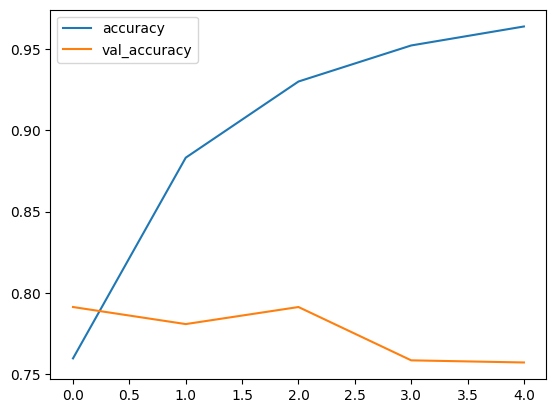

In [ ]:
history_1_df = pd.DataFrame(model_1_history.history)[['accuracy', 'val_accuracy']]
history_1_df.plot()

In [ ]:
# lets see how model_1 predictions looks like
model_1_predictions = model_1.predict(test_texts)
model_1_predictions[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.17212205],
       [0.04949871],
       [0.00534902],
       [0.4307658 ],
       [0.05076183],
       [0.962056  ],
       [0.01596476],
       [0.00100851],
       [0.00740526],
       [0.02328215]], dtype=float32)

In [ ]:
model_1_predictions.shape

(762, 1)

In [ ]:
# sigmoid functions returns probability instead of predicted label
# also probas needs reshaping
# let's write function to convert propabilitier to predicted labels

def calculate_preds(model, test_data=test_texts):
  probas = model.predict(test_data)
  labels = tf.squeeze(tf.round(probas))
  return labels

In [ ]:
model_1_predictions = calculate_preds(model_1)
model_1_predictions[:10]

24/24 [==============================] - 0s 12ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
model_1_metrics = get_model_metrics(model_1_predictions)
model_1_metrics

{'accuracy': 0.7572178477690289,
 'precision': 0.7759364809765938,
 'recall': 0.7572178477690289,
 'f1': 0.7620675458790892}

In [ ]:
model_2 = Sequential()

model_2.add(layers.Input(shape=(1,), dtype=tf.string))
model_2.add(vectorizer)
model_2.add(layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=256,
    input_length=max_length,
))
model_2.add(layers.LSTM(units=64, dropout=0.4, recurrent_dropout=0.4))
model_2.add(layers.Dense(16, activation='relu', kernel_regularizer='l2'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
    )

In [ ]:
model_2_history = model_2.fit(
    x=train_texts,
    y=train_labels,
    epochs=5,
    validation_data=(test_texts, test_labels)
)

Epoch 1/5
215/215 [==============================] - 20s 75ms/step - loss: 0.9037 - accuracy: 0.5792 - val_loss: 0.8614 - val_accuracy: 0.6115
Epoch 2/5
215/215 [==============================] - 16s 75ms/step - loss: 0.8185 - accuracy: 0.6822 - val_loss: 0.7145 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 17s 79ms/step - loss: 0.6230 - accuracy: 0.8148 - val_loss: 0.6064 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 16s 76ms/step - loss: 0.5252 - accuracy: 0.8570 - val_loss: 0.5817 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 16s 76ms/step - loss: 0.4600 - accuracy: 0.8809 - val_loss: 0.5834 - val_accuracy: 0.7861


<Axes: >

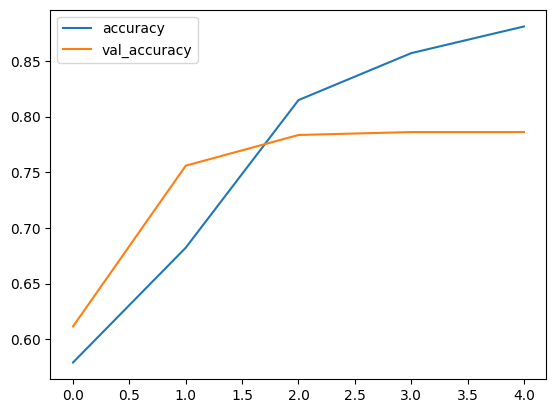

In [ ]:
history_2_df = pd.DataFrame(model_2_history.history)[['accuracy', 'val_accuracy']]
history_2_df.plot()

In [ ]:
# arrucacy curver looks much better, but despite of many regularization
# model is still overfitting in 5 epochs and results are worse than base model

In [ ]:
# lets try universal sentence encoder from tensorflow hub - the most downloaded model from embedding section

# use example from tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [ ]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype="string",
    name="USE"
)

In [ ]:
model_3 = Sequential()

model_3.add(use_layer)
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.4))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

In [ ]:
model_3_history = model_3.fit(
    x=train_texts,
    y=train_labels,
    epochs=5,
    validation_data=(test_texts, test_labels)
)

Epoch 1/5
215/215 [==============================] - 8s 18ms/step - loss: 0.5392 - accuracy: 0.7647 - val_loss: 0.4703 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4428 - accuracy: 0.7986 - val_loss: 0.4548 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4301 - accuracy: 0.8056 - val_loss: 0.4527 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4198 - accuracy: 0.8130 - val_loss: 0.4503 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4107 - accuracy: 0.8180 - val_loss: 0.4504 - val_accuracy: 0.7769


In [ ]:
# ok, results are better and the most important thing is that model is not overfitting
# lets implemment early stopping, and increase epochs

In [ ]:
model_4 = tf.keras.Sequential()

model_4.add(use_layer)
model_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_4.add(tf.keras.layers.Dropout(0.5))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

In [ ]:
model_4_history = model_4.fit(
    x=train_texts,
    y=train_labels,
    epochs=100,
    validation_data=(test_texts, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/100
215/215 [==============================] - 9s 31ms/step - loss: 0.5435 - accuracy: 0.7551 - val_loss: 0.4729 - val_accuracy: 0.7690
Epoch 2/100
215/215 [==============================] - 6s 29ms/step - loss: 0.4491 - accuracy: 0.7977 - val_loss: 0.4582 - val_accuracy: 0.7730
Epoch 3/100
215/215 [==============================] - 4s 19ms/step - loss: 0.4325 - accuracy: 0.8095 - val_loss: 0.4558 - val_accuracy: 0.7795
Epoch 4/100
215/215 [==============================] - 3s 12ms/step - loss: 0.4213 - accuracy: 0.8113 - val_loss: 0.4567 - val_accuracy: 0.7743
Epoch 5/100
215/215 [==============================] - 5s 22ms/step - loss: 0.4162 - accuracy: 0.8124 - val_loss: 0.4543 - val_accuracy: 0.7782
Epoch 6/100
215/215 [==============================] - 5s 21ms/step - loss: 0.4094 - accuracy: 0.8206 - val_loss: 0.4533 - val_accuracy: 0.7808
Epoch 7/100
215/215 [==============================] - 3s 13ms/step - loss: 0.4039 - accuracy: 0.8199 - val_loss: 0.4540 - val_accuracy:

In [ ]:
model_4_preds = calculate_preds(model_4)

24/24 [==============================] - 1s 9ms/step


In [ ]:
model_4_results = get_model_metrics(model_4_preds)

In [ ]:
model_4_results

{'accuracy': 0.7782152230971129,
 'precision': 0.7874609678762108,
 'recall': 0.7782152230971129,
 'f1': 0.7807940739124446}

In [ ]:
basic_metrics

{'accuracy': 0.7874015748031497,
 'precision': 0.806895664049133,
 'recall': 0.7874015748031497,
 'f1': 0.791945948990009}

Results from model 4 are quite good considering that dataset is rather small and tweets are written in short, informal language. Also the line between determining whether something is a description of a disaster or not is very thin and depends on context (retweets, comments e.t.c)

Let's use model_4 for kaggle competition and create file in proper format for submission.

In [ ]:
sample_submission_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [ ]:
test_texts = test_df['cleaned_text'].to_numpy()

In [ ]:
test_preds = calculate_preds(model_4, test_data=test_texts)

102/102 [==============================] - 1s 11ms/step


In [ ]:
test_preds

<tf.Tensor: shape=(3263,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 0.], dtype=float32)>

In [ ]:
submission_df = pd.DataFrame(zip(test_df.id, np.array(test_preds)), columns=['id', 'target'])

In [ ]:
submission_df = submission_df.astype({'target': int})

In [ ]:
submission_df

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submission_df.to_csv("submission.csv", index=False)